In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tqdm


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import imagesize
import imageio

### load and process the data for training

In [2]:
DATA_PATH = r'../../data/'

In [3]:
CUB_PATH = DATA_PATH + 'CUB_200_2011/'

In [4]:
cub_df = pd.read_csv(CUB_PATH + 'images.txt', header=None, delimiter=' ')
cub_df.columns = ['id', 'fname']

In [5]:
cub_bbs = pd.read_csv(CUB_PATH + 'bounding_boxes.txt', header=None, delimiter= ' ')
cub_bbs.columns = ['id', 'x_bb', 'y_bb', 'width', 'height']

In [6]:
cub_df = pd.merge(cub_df, cub_bbs, on='id')

In [7]:
NABIRDS_PATH = DATA_PATH + 'nabirds/'

In [8]:
LOAD_DIR = NABIRDS_PATH + 'images/'

In [9]:
nabirds_df = pd.read_csv(NABIRDS_PATH + 'images.txt', header=None, delimiter=' ')
nabirds_df.columns = ['id', 'fname']

In [10]:
nabirds_bbs = pd.read_csv(NABIRDS_PATH + 'bounding_boxes.txt', header=None, delimiter= ' ')
nabirds_bbs.columns = ['id', 'x_bb', 'y_bb', 'width', 'height']

In [11]:
nabirds_df = pd.merge(nabirds_df, nabirds_bbs, on='id')

In [12]:
list(nabirds_df), list(cub_df)

(['id', 'fname', 'x_bb', 'y_bb', 'width', 'height'],
 ['id', 'fname', 'x_bb', 'y_bb', 'width', 'height'])

In [13]:
nabirds_df['load_path'] = nabirds_df['fname'].apply(lambda x: r'../../data/nabirds/images/%s'%x)
cub_df['load_path'] = cub_df['fname'].apply(lambda x: r'../../data/CUB_200_2011/images/%s'%x)

In [14]:
df = pd.concat([nabirds_df, cub_df])
df.sample(5)

,id,fname,x_bb,y_bb,width,height,load_path
35647,bb918978-cd34-4860-8e14-c622f3d86c0a,0313/bb918978cd3448608e14c622f3d86c0a.jpg,95.0,119.0,865.0,399.0,../../data/nabirds/images/0313/bb918978cd34486...
3145,10b328ee-3b87-4f91-bd35-b509e1a0fe20,0333/10b328ee3b874f91bd35b509e1a0fe20.jpg,159.0,148.0,450.0,189.0,../../data/nabirds/images/0333/10b328ee3b874f9...
37211,c3c65eeb-96fc-40a8-95d4-c214b181dc24,0360/c3c65eeb96fc40a895d4c214b181dc24.jpg,344.0,77.0,273.0,542.0,../../data/nabirds/images/0360/c3c65eeb96fc40a...
6047,202faeaf-84ea-4e8b-a380-7ea9f75642a2,0655/202faeaf84ea4e8ba3807ea9f75642a2.jpg,496.0,319.0,221.0,149.0,../../data/nabirds/images/0655/202faeaf84ea4e8...
10391,37291d20-e26e-47d6-a677-a4ccc9dc15a8,0819/37291d20e26e47d6a677a4ccc9dc15a8.jpg,301.0,92.0,333.0,624.0,../../data/nabirds/images/0819/37291d20e26e47d...


In [15]:
def show_row(row):
    img = imageio.imread(row['load_path'])
    ax = plt.gca()
    ax.imshow(img)
    rect = patches.Rectangle((row['x_bb'], row['y_bb']), row['width'], row['height'], facecolor='none', edgecolor='r', linewidth=3)
    ax.add_patch(rect)
    plt.show()
    

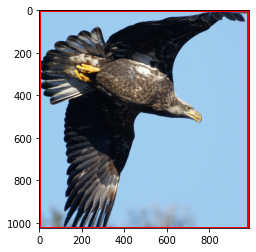

In [16]:
show_row(df.sample(1, random_state=None).iloc[0])

In [17]:
np.random.seed(42)
train_indexer = np.random.rand(df.shape[0]) < .8
df['train'] = train_indexer

In [ ]:
df['img_width'] = -1
df['img_height'] = -1

In [ ]:
test_path = df.sample(1).iloc[0]['load_path']
imageio.imread(test_path).shape, imagesize.get(test_path)

In [18]:
def add_img_dim_to_row(row, just_test=False):
    if just_test and row['train']:
        row['img_width'] = 1
        row['img_height'] = 1
    else:
        width, height = imagesize.get(row['load_path'])
        row['img_width'] = width
        row['img_height'] = height
    return row

In [19]:
tqdm.tqdm.pandas()

In [20]:
df = df.progress_apply(add_img_dim_to_row, axis=1, just_test = True)

100%|██████████| 60350/60350 [05:29<00:00, 182.91it/s]


In [21]:
assert df['img_width'].min() > 0
assert df['img_height'].min() > 0

In [22]:
train_df = df[df['train']].reset_index(drop=True)
test_df = df[~df['train']].reset_index(drop=True)
train_df.shape, test_df.shape

((48347, 10), (12003, 10))

In [23]:
train_df.sample(5)

,id,fname,x_bb,y_bb,width,height,load_path,train,img_width,img_height
5234,228b829e-74dc-4cb2-b339-8e3f46175ba1,0964/228b829e74dc4cb2b3398e3f46175ba1.jpg,38.0,140.0,737.0,363.0,../../data/nabirds/images/0964/228b829e74dc4cb...,True,1,1
39968,1315,024.Red_faced_Cormorant/Red_Faced_Cormorant_00...,141.0,53.0,167.0,398.0,../../data/CUB_200_2011/images/024.Red_faced_C...,True,1,1
21169,8aea829c-72d0-4aea-855d-29e0a35e1faf,0340/8aea829c72d04aea855d29e0a35e1faf.jpg,15.0,90.0,711.0,434.0,../../data/nabirds/images/0340/8aea829c72d04ae...,True,1,1
15481,661621d4-a14e-487c-8c74-354134a29710,0898/661621d4a14e487c8c74354134a29710.jpg,152.0,224.0,626.0,378.0,../../data/nabirds/images/0898/661621d4a14e487...,True,1,1
36759,f1d68b6c-9f7b-49b6-b213-758c59f4b0f6,0827/f1d68b6c9f7b49b6b213758c59f4b0f6.jpg,141.0,125.0,466.0,500.0,../../data/nabirds/images/0827/f1d68b6c9f7b49b...,True,1,1


In [24]:
class BirdDataset(object):
    def __init__(self, this_df, transforms):
        self.information_dict = this_df.to_dict(orient='index')
        self.transforms = transforms
        
    def __getitem__(self, idx):
        this_row = self.information_dict[idx]
        img = Image.open(this_row['load_path']).convert('RGB')
        boxes = [[this_row['x_bb'], this_row['y_bb'], this_row['x_bb'] + this_row['width'], 
                  this_row['y_bb'] + this_row['height']]]
        
        boxes = torch.tensor(boxes, dtype=torch.float)
        labels = torch.ones((1,), dtype=torch.long)
        image_id = torch.tensor([idx])
        area = torch.tensor(this_row['width'] * this_row['height'], dtype=torch.float).view((1,))
        is_crowd = torch.zeros((1,), dtype=torch.long)
        target = {
            'boxes' : boxes,
            'labels' : labels,
            'image_id' : image_id,
            'area' : area,
            'iscrowd' : is_crowd,
        }
        

        if self.transforms is not None:
            img, target = self.transforms(img, target)
            
        return img, target
            
    def __len__(self):
        return len(self.information_dict)
        

### Make the model

In [25]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [26]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, rpn_nms_thresh=0.5, box_score_thresh=.5)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

#### Make the dataloaders

In [27]:
import sys
sys.path.append('../../src/torchvision_references/')
import transforms as T
from engine import train_one_epoch, evaluate
import utils

In [28]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [29]:
train_dataset = BirdDataset(train_df, get_transform(train=True))
test_dataset = BirdDataset(test_df, get_transform(train=False))

In [30]:
data_loader_train = torch.utils.data.DataLoader(
        train_dataset, batch_size=1, shuffle=True, num_workers=0,
        collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
        test_dataset, batch_size=4, shuffle=False, num_workers=0,
        collate_fn=utils.collate_fn)

In [31]:
device = torch.device('cuda')

In [32]:
device

device(type='cuda')

In [33]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [34]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [35]:
# uncomment to train 

# num_epochs = 6

# for epoch in range(num_epochs):
#     # train for one epoch, printing every 10 iterations
    
#     train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=500, max_epoch_size = 8000)

#     # update the learning rate
#     lr_scheduler.step()
#     # evaluate on the test dataset
#     evaluate(model, data_loader_test, device=device)
#     torch.save(model.state_dict(), 'faster_rcnn%d.pt'%epoch)
# # torch.save(model.state_dict(), 'faster_rcnn.pt')

### Evaluate Model

In [36]:
model.load_state_dict(torch.load('../../models/segmentation/faster_rcnn.pt'))

<All keys matched successfully>

In [37]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [38]:
def show_img_tensor(img):
    plt.imshow(np.moveaxis(img.data.cpu().numpy(), (0,1,2), (2,0,1)))
    plt.show()

In [39]:
import importlib
import engine
importlib.reload(engine)
from engine import evaluate

In [40]:
evaluate(model, data_loader_test, device=device)

100%|██████████| 12003/12003 [08:07<00:00, 38.23it/s]

creating index...
index created!


/home/Sam/.local/lib/python3.6/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Test:  [   0/3001]  eta: 0:19:54  model_time: 0.3274 (0.3274)  evaluator_time: 0.0042 (0.0042)  time: 0.3982  data: 0.0589  max mem: 2510
Test:  [   5/3001]  eta: 0:17:31  model_time: 0.2696 (0.2797)  evaluator_time: 0.0042 (0.0042)  time: 0.3510  data: 0.0597  max mem: 2510
Test:  [  10/3001]  eta: 0:17:58  model_time: 0.2696 (0.2900)  evaluator_time: 0.0042 (0.0042)  time: 0.3607  data: 0.0591  max mem: 3364
Test:  [  15/3001]  eta: 0:17:36  model_time: 0.2621 (0.2822)  evaluator_time: 0.0042 (0.0042)  time: 0.3537  data: 0.0598  max mem: 3364
Test:  [  20/3001]  eta: 0:17:43  model_time: 0.2621 (0.2851)  evaluator_time: 0.0042 (0.0042)  time: 0.3547  data: 0.0599  max mem: 3364
Test:  [  25/3001]  eta: 0:17:39  model_time: 0.2484 (0.2844)  evaluator_time: 0.0042 (0.0042)  time: 0.3574  data: 0.0598  max mem: 3364
Test:  [  30/3001]  eta: 0:17:45  model_time: 0.2484 (0.2856)  evaluator_time: 0.0042 (0.0042)  time: 0.3576  data: 0.0622  max mem: 3364


100%|██████████| 12003/12003 [08:20<00:00, 38.23it/s]

Test:  [  35/3001]  eta: 0:17:35  model_time: 0.2484 (0.2826)  evaluator_time: 0.0042 (0.0043)  time: 0.3574  data: 0.0621  max mem: 3364
Test:  [  40/3001]  eta: 0:17:45  model_time: 0.2787 (0.2855)  evaluator_time: 0.0042 (0.0043)  time: 0.3633  data: 0.0650  max mem: 3364
Test:  [  45/3001]  eta: 0:17:43  model_time: 0.2787 (0.2842)  evaluator_time: 0.0042 (0.0043)  time: 0.3644  data: 0.0678  max mem: 3364
Test:  [  50/3001]  eta: 0:17:41  model_time: 0.2787 (0.2846)  evaluator_time: 0.0042 (0.0043)  time: 0.3614  data: 0.0659  max mem: 3364
Test:  [  55/3001]  eta: 0:17:35  model_time: 0.2676 (0.2831)  evaluator_time: 0.0041 (0.0043)  time: 0.3628  data: 0.0666  max mem: 3364
Test:  [  60/3001]  eta: 0:17:33  model_time: 0.2639 (0.2829)  evaluator_time: 0.0041 (0.0043)  time: 0.3542  data: 0.0644  max mem: 3364
Test:  [  65/3001]  eta: 0:17:25  model_time: 0.2619 (0.2804)  evaluator_time: 0.0041 (0.0042)  time: 0.3482  data: 0.0643  max mem: 3364
Test:  [  70/3001]  eta: 0:17:26  

Test:  [ 335/3001]  eta: 0:15:48  model_time: 0.2481 (0.2809)  evaluator_time: 0.0041 (0.0042)  time: 0.3368  data: 0.0613  max mem: 3364
Test:  [ 340/3001]  eta: 0:15:45  model_time: 0.2527 (0.2805)  evaluator_time: 0.0041 (0.0042)  time: 0.3319  data: 0.0592  max mem: 3364
Test:  [ 345/3001]  eta: 0:15:43  model_time: 0.2499 (0.2806)  evaluator_time: 0.0041 (0.0042)  time: 0.3318  data: 0.0583  max mem: 3364
Test:  [ 350/3001]  eta: 0:15:40  model_time: 0.2527 (0.2802)  evaluator_time: 0.0041 (0.0042)  time: 0.3335  data: 0.0601  max mem: 3364
Test:  [ 355/3001]  eta: 0:15:39  model_time: 0.2573 (0.2802)  evaluator_time: 0.0041 (0.0042)  time: 0.3414  data: 0.0610  max mem: 3364
Test:  [ 360/3001]  eta: 0:15:37  model_time: 0.2649 (0.2804)  evaluator_time: 0.0041 (0.0042)  time: 0.3525  data: 0.0626  max mem: 3364
Test:  [ 365/3001]  eta: 0:15:35  model_time: 0.2573 (0.2803)  evaluator_time: 0.0041 (0.0042)  time: 0.3494  data: 0.0626  max mem: 3364
Test:  [ 370/3001]  eta: 0:15:33  

Test:  [ 635/3001]  eta: 0:14:03  model_time: 0.2527 (0.2816)  evaluator_time: 0.0041 (0.0042)  time: 0.3361  data: 0.0623  max mem: 3364
Test:  [ 640/3001]  eta: 0:14:02  model_time: 0.2534 (0.2817)  evaluator_time: 0.0041 (0.0042)  time: 0.3426  data: 0.0595  max mem: 3364
Test:  [ 645/3001]  eta: 0:14:00  model_time: 0.2613 (0.2817)  evaluator_time: 0.0041 (0.0042)  time: 0.3482  data: 0.0619  max mem: 3364
Test:  [ 650/3001]  eta: 0:13:58  model_time: 0.2675 (0.2817)  evaluator_time: 0.0041 (0.0042)  time: 0.3564  data: 0.0616  max mem: 3364
Test:  [ 655/3001]  eta: 0:13:56  model_time: 0.2588 (0.2817)  evaluator_time: 0.0040 (0.0042)  time: 0.3567  data: 0.0614  max mem: 3364
Test:  [ 660/3001]  eta: 0:13:55  model_time: 0.2588 (0.2817)  evaluator_time: 0.0040 (0.0042)  time: 0.3551  data: 0.0630  max mem: 3364
Test:  [ 665/3001]  eta: 0:13:53  model_time: 0.2588 (0.2817)  evaluator_time: 0.0040 (0.0042)  time: 0.3534  data: 0.0618  max mem: 3364
Test:  [ 670/3001]  eta: 0:13:51  

Test:  [ 935/3001]  eta: 0:12:15  model_time: 0.2672 (0.2810)  evaluator_time: 0.0041 (0.0042)  time: 0.3575  data: 0.0628  max mem: 3364
Test:  [ 940/3001]  eta: 0:12:13  model_time: 0.2486 (0.2810)  evaluator_time: 0.0041 (0.0042)  time: 0.3497  data: 0.0616  max mem: 3364
Test:  [ 945/3001]  eta: 0:12:11  model_time: 0.2479 (0.2808)  evaluator_time: 0.0041 (0.0042)  time: 0.3412  data: 0.0629  max mem: 3364
Test:  [ 950/3001]  eta: 0:12:09  model_time: 0.2479 (0.2808)  evaluator_time: 0.0041 (0.0042)  time: 0.3487  data: 0.0676  max mem: 3364
Test:  [ 955/3001]  eta: 0:12:07  model_time: 0.2479 (0.2808)  evaluator_time: 0.0040 (0.0042)  time: 0.3478  data: 0.0656  max mem: 3364
Test:  [ 960/3001]  eta: 0:12:06  model_time: 0.2616 (0.2809)  evaluator_time: 0.0041 (0.0042)  time: 0.3553  data: 0.0666  max mem: 3364
Test:  [ 965/3001]  eta: 0:12:04  model_time: 0.2924 (0.2809)  evaluator_time: 0.0041 (0.0042)  time: 0.3632  data: 0.0631  max mem: 3364
Test:  [ 970/3001]  eta: 0:12:02  

Test:  [1235/3001]  eta: 0:10:27  model_time: 0.3045 (0.2806)  evaluator_time: 0.0041 (0.0042)  time: 0.3659  data: 0.0613  max mem: 3364
Test:  [1240/3001]  eta: 0:10:25  model_time: 0.2640 (0.2806)  evaluator_time: 0.0041 (0.0042)  time: 0.3536  data: 0.0576  max mem: 3364
Test:  [1245/3001]  eta: 0:10:23  model_time: 0.2652 (0.2807)  evaluator_time: 0.0041 (0.0042)  time: 0.3555  data: 0.0579  max mem: 3364
Test:  [1250/3001]  eta: 0:10:22  model_time: 0.2921 (0.2808)  evaluator_time: 0.0041 (0.0042)  time: 0.3652  data: 0.0573  max mem: 3364
Test:  [1255/3001]  eta: 0:10:20  model_time: 0.3048 (0.2809)  evaluator_time: 0.0041 (0.0042)  time: 0.3688  data: 0.0567  max mem: 3364
Test:  [1260/3001]  eta: 0:10:18  model_time: 0.2921 (0.2808)  evaluator_time: 0.0041 (0.0042)  time: 0.3653  data: 0.0584  max mem: 3364
Test:  [1265/3001]  eta: 0:10:16  model_time: 0.2926 (0.2809)  evaluator_time: 0.0041 (0.0042)  time: 0.3633  data: 0.0591  max mem: 3364
Test:  [1270/3001]  eta: 0:10:14  

Test:  [1535/3001]  eta: 0:08:39  model_time: 0.2615 (0.2802)  evaluator_time: 0.0041 (0.0041)  time: 0.3495  data: 0.0651  max mem: 3364
Test:  [1540/3001]  eta: 0:08:38  model_time: 0.2650 (0.2801)  evaluator_time: 0.0041 (0.0041)  time: 0.3515  data: 0.0655  max mem: 3364
Test:  [1545/3001]  eta: 0:08:36  model_time: 0.2586 (0.2801)  evaluator_time: 0.0041 (0.0041)  time: 0.3512  data: 0.0642  max mem: 3364
Test:  [1550/3001]  eta: 0:08:34  model_time: 0.2654 (0.2801)  evaluator_time: 0.0041 (0.0041)  time: 0.3545  data: 0.0636  max mem: 3364
Test:  [1555/3001]  eta: 0:08:32  model_time: 0.2450 (0.2801)  evaluator_time: 0.0041 (0.0041)  time: 0.3484  data: 0.0630  max mem: 3364
Test:  [1560/3001]  eta: 0:08:30  model_time: 0.2450 (0.2801)  evaluator_time: 0.0041 (0.0041)  time: 0.3482  data: 0.0614  max mem: 3364
Test:  [1565/3001]  eta: 0:08:29  model_time: 0.2648 (0.2801)  evaluator_time: 0.0041 (0.0041)  time: 0.3533  data: 0.0628  max mem: 3364
Test:  [1570/3001]  eta: 0:08:27  

Test:  [1835/3001]  eta: 0:06:53  model_time: 0.2777 (0.2801)  evaluator_time: 0.0039 (0.0041)  time: 0.3562  data: 0.0622  max mem: 3364
Test:  [1840/3001]  eta: 0:06:51  model_time: 0.2882 (0.2801)  evaluator_time: 0.0040 (0.0041)  time: 0.3588  data: 0.0602  max mem: 3364
Test:  [1845/3001]  eta: 0:06:49  model_time: 0.2899 (0.2800)  evaluator_time: 0.0040 (0.0041)  time: 0.3636  data: 0.0604  max mem: 3364
Test:  [1850/3001]  eta: 0:06:47  model_time: 0.2796 (0.2800)  evaluator_time: 0.0040 (0.0041)  time: 0.3608  data: 0.0612  max mem: 3364
Test:  [1855/3001]  eta: 0:06:46  model_time: 0.2728 (0.2801)  evaluator_time: 0.0040 (0.0041)  time: 0.3570  data: 0.0645  max mem: 3364
Test:  [1860/3001]  eta: 0:06:44  model_time: 0.2531 (0.2800)  evaluator_time: 0.0040 (0.0041)  time: 0.3533  data: 0.0679  max mem: 3364
Test:  [1865/3001]  eta: 0:06:42  model_time: 0.2663 (0.2800)  evaluator_time: 0.0039 (0.0041)  time: 0.3573  data: 0.0669  max mem: 3364
Test:  [1870/3001]  eta: 0:06:40  

Test:  [2135/3001]  eta: 0:05:06  model_time: 0.2847 (0.2800)  evaluator_time: 0.0038 (0.0041)  time: 0.3649  data: 0.0617  max mem: 3364
Test:  [2140/3001]  eta: 0:05:04  model_time: 0.2797 (0.2800)  evaluator_time: 0.0039 (0.0041)  time: 0.3617  data: 0.0623  max mem: 3364
Test:  [2145/3001]  eta: 0:05:03  model_time: 0.2788 (0.2800)  evaluator_time: 0.0039 (0.0041)  time: 0.3522  data: 0.0604  max mem: 3364
Test:  [2150/3001]  eta: 0:05:01  model_time: 0.2529 (0.2799)  evaluator_time: 0.0040 (0.0041)  time: 0.3444  data: 0.0589  max mem: 3364
Test:  [2155/3001]  eta: 0:04:59  model_time: 0.2482 (0.2799)  evaluator_time: 0.0040 (0.0041)  time: 0.3423  data: 0.0595  max mem: 3364
Test:  [2160/3001]  eta: 0:04:57  model_time: 0.2482 (0.2799)  evaluator_time: 0.0039 (0.0041)  time: 0.3352  data: 0.0560  max mem: 3364
Test:  [2165/3001]  eta: 0:04:56  model_time: 0.2529 (0.2799)  evaluator_time: 0.0039 (0.0041)  time: 0.3449  data: 0.0580  max mem: 3364
Test:  [2170/3001]  eta: 0:04:54  

Test:  [2435/3001]  eta: 0:03:19  model_time: 0.2531 (0.2797)  evaluator_time: 0.0038 (0.0041)  time: 0.3149  data: 0.0255  max mem: 3364
Test:  [2440/3001]  eta: 0:03:18  model_time: 0.2531 (0.2797)  evaluator_time: 0.0039 (0.0041)  time: 0.3052  data: 0.0179  max mem: 3364
Test:  [2445/3001]  eta: 0:03:16  model_time: 0.2440 (0.2796)  evaluator_time: 0.0039 (0.0041)  time: 0.3005  data: 0.0188  max mem: 3364
Test:  [2450/3001]  eta: 0:03:14  model_time: 0.2531 (0.2796)  evaluator_time: 0.0039 (0.0041)  time: 0.3043  data: 0.0200  max mem: 3364
Test:  [2455/3001]  eta: 0:03:12  model_time: 0.2490 (0.2796)  evaluator_time: 0.0039 (0.0041)  time: 0.2954  data: 0.0206  max mem: 3364
Test:  [2460/3001]  eta: 0:03:10  model_time: 0.2490 (0.2796)  evaluator_time: 0.0039 (0.0041)  time: 0.2998  data: 0.0211  max mem: 3364
Test:  [2465/3001]  eta: 0:03:08  model_time: 0.2602 (0.2796)  evaluator_time: 0.0039 (0.0041)  time: 0.3058  data: 0.0203  max mem: 3364
Test:  [2470/3001]  eta: 0:03:07  

Test:  [2735/3001]  eta: 0:01:32  model_time: 0.2437 (0.2792)  evaluator_time: 0.0038 (0.0041)  time: 0.2825  data: 0.0196  max mem: 3364
Test:  [2740/3001]  eta: 0:01:30  model_time: 0.2474 (0.2792)  evaluator_time: 0.0038 (0.0041)  time: 0.2886  data: 0.0197  max mem: 3364
Test:  [2745/3001]  eta: 0:01:28  model_time: 0.2530 (0.2792)  evaluator_time: 0.0039 (0.0041)  time: 0.3001  data: 0.0196  max mem: 3364
Test:  [2750/3001]  eta: 0:01:27  model_time: 0.2649 (0.2792)  evaluator_time: 0.0039 (0.0041)  time: 0.3086  data: 0.0194  max mem: 3364
Test:  [2755/3001]  eta: 0:01:25  model_time: 0.2598 (0.2792)  evaluator_time: 0.0039 (0.0041)  time: 0.3062  data: 0.0194  max mem: 3364
Test:  [2760/3001]  eta: 0:01:23  model_time: 0.2857 (0.2792)  evaluator_time: 0.0039 (0.0041)  time: 0.3154  data: 0.0202  max mem: 3364
Test:  [2765/3001]  eta: 0:01:21  model_time: 0.2651 (0.2792)  evaluator_time: 0.0039 (0.0041)  time: 0.3078  data: 0.0205  max mem: 3364
Test:  [2770/3001]  eta: 0:01:20  

### Seems to be working. YAY! :)

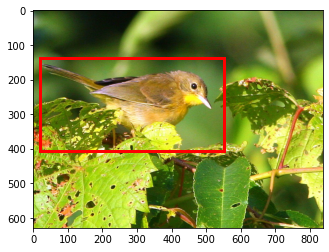

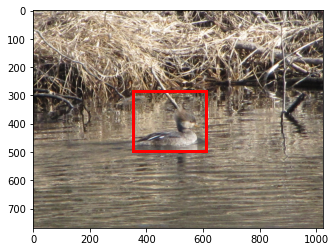

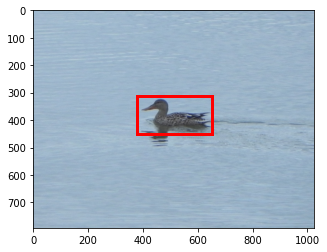

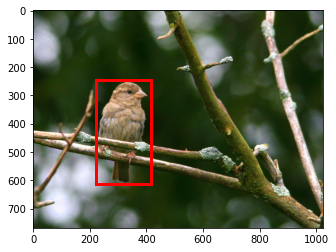

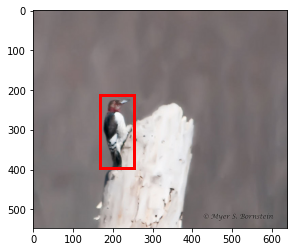

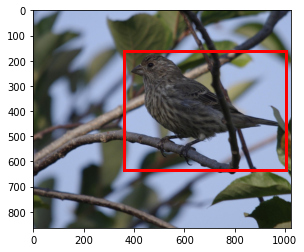

In [42]:
counter = 0
for image, target in data_loader_test:
    counter+=1
    if np.random.rand() > .01: continue
    image_out = image[0]
    ax = plt.gca()
    plt.imshow(np.moveaxis(image_out.data.cpu().numpy(), (0,1,2), (2,0,1)))
    
    
    image = list(img.to(device) for img in image)
    res = model(image)[0]
    for box in res['boxes']:
        box = box.data.cpu().numpy()
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3]-box[1], facecolor='none', edgecolor='r', linewidth=3)
        ax.add_patch(rect)
    
    plt.show()
    if np.random.rand() < .1: break

#### Now.... apply it to the oriental-bird-database data

In [ ]:
obd_path = '../data/raw/oriental_bird_database/'

In [ ]:
obd_df = pd.read_csv(obd_path + 'labels.csv')

In [ ]:
def add_image_path_to_obd(row):
    row['load_path'] = obd_path + 'images/%d_%d.jpg'%(row['bird_id'], row['image_id'])
    return row

In [ ]:
obd_df.shape

In [ ]:
obd_df.head(5)

In [ ]:
obd_df = obd_df.progress_apply(add_image_path_to_obd, axis=1)

In [ ]:
obd_df['x_bb'] = -1
obd_df['y_bb'] = -1
obd_df['width_bb'] = -1
obd_df['height_bb'] = -1
obd_df['have_image'] = False

In [ ]:
def obd_predict(row, show=False):
    try:
        img = np.array(Image.open(row['load_path']).convert('RGB'))
    except FileNotFoundError:
        return row
    row['have_image'] = True
    img = img / 255
    if show:
        ax = plt.gca()
        ax.imshow(img)
    img_tensor = [torch.tensor(np.moveaxis(img, (0,1,2), (1,2,0)), dtype=torch.float, device=device)]
    res = model(img_tensor)[0]
    x_bbs = []
    y_bbs = []
    width_bbs = []
    height_bbs = []
    
    for box in res['boxes']:
        box = box.data.cpu().numpy()
        x_bbs.append(box[0])
        y_bbs.append(box[1])
        width_bbs.append(box[2] - box[0])
        height_bbs.append(box[3]-box[1])
        if show:
            rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3]-box[1], facecolor='none', edgecolor='r', linewidth=3)
            ax.add_patch(rect)
    
    if show:
        plt.show()
        
    assert len(x_bbs)==len(y_bbs)==len(width_bbs)==len(height_bbs)
    
    
    if len(x_bbs)==0:
        return row
    elif len(x_bbs)==1:
        row['x_bb'] = x_bbs[0]
        row['y_bb'] = y_bbs[0]
        row['width_bb'] = width_bbs[0]
        row['height_bb'] = height_bbs[0]
    else:
        row['x_bb'] = x_bbs
        row['y_bb'] = y_bbs
        row['width_bb'] = width_bbs
        row['height_bb'] = height_bbs
        
    return row

In [ ]:
obd_df = obd_df.progress_apply(obd_predict, axis=1, show=False)

In [ ]:
obd_df.to_csv('obd_updated_labels.csv')

In [ ]:
obd_predict(obd_df.iloc[2231])